# Exercise 5 - Deep Learning
## Andreas Kocman (se19m024)

## Assignment
### Description
The main goal of this exercise is to work with Deep Learning approaches, either for image or for sequential data, depending on your preference / experience / interest to learn.
Thus. you shall use approaches such as convolutional neural networks (for images) or recurrent neural networks (for text)
For images, you can base your DL implementation on the tutorial provided by colleagues at TU Wien, available at https://github.com/tuwien-musicir/DL_Tutorial/blob/master/Car_recognition.ipynb (you can also check the rest of the repository for interesting code; credit to Thomas Lidy (http://www.ifs.tuwien.ac.at/~lidy/)).
For the dataset you shall work with, pick one of the text/image datasets from the list of suggestions below. If you have proposals for other datasets, please inform me (rmayer@technikum-wien.at), and we can see if the dataset is fit.

#### For Images:
* The German Traffic Sign Recognition Benchmark (GTSRB), http://benchmark.ini.rub.de/
* AT&T (Olivetti) Faces: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html, https://scikit-learn.org/0.19/datasets/olivetti_faces.html
* Yale Face Database: http://vision.ucsd.edu/content/yale-face-database
* CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html
* Tiny ImageNet: https://tiny-imagenet.herokuapp.com/
* Labeled Faces in the Wild, http://vis-www.cs.umass.edu/lfw/, using the task for face recognition. See also https://scikit-learn.org/0.19/datasets/#the-labeled-faces-in-the-wild-face-recognition-dataset

#### For Text Data:
* 20 newsgroups: http://qwone.com/~jason/20Newsgroups/
* Reuters: http://www.daviddlewis.com/resources/testcollections/reuters21578/

### Recommendations for CNNs specifically:
* Use architectures of your choice – you can work with something simple like a LeNet, or a bit more advanced architectures (where maybe transfer learning is required for efficiency reasons, see below).
* Use as well data augmentation (you can reuse the code from the tutorial), and compare it to the non-augmented results
* Also consider using transfer learning of pre-trained models


If you do want to work in a group of up to three students, this is also possible, then the task would be slightly extended, to either
* Choosing three datasets (you shall chose only one of the AT&T and Yale Face datasets, but not both of them, as they are both relatively small)
* Or a comparison to non-DL based approaches for image / text classification (for image, some of you already did this in exercise 4). Specifically, in this case, follow the instructions below.

### Comparison to feature-extraction based approaches (group work, 3 students):
The main goal of this exercise is to get a feeling and understanding on the importance of representation of complex media content, in this case images or text. You will thus get some datasets that have an image classification target.
(1) In the first step, you shall try to find a good classifier with „traditional“ feature extraction methods. Thus, pick
* For Images
  * One simple feature representation (such as a colour histogram, see also the example provided in Moodle for the previous exercise) and
  * A feature extractor based on SIFT (https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) and subsequent visual bag of words (e.g. https://kushalvyas.github.io/BOV.html for python), or a similar powerful approach (such as SURF, HOG, ..).

* For Text
  * One feature extractor based on e.g. Bag Of Words, or n-grams, or similar
You shall evaluate these features on a couple of non-DL algorithms (for image, also specifically including a simple MLP), and parameter settings to see what performance you can achieve, to have a baseline for the subsequent steps.

Compare not just the overall measures, but perform a detailed comparison and analysis per class (confusion matrix), to identify if the two approaches lead to different types of errors in the different classes, and also try to identify other patterns. Also perform a detailed comparison of runtime, considering both time for training and testing, including also the feature extraction components.

## Solution

### Sources used
* [Car Recognition with Deep Learning](https://github.com/tuwien-musicir/DeepLearning_Tutorial/blob/master/Car_recognition.ipynb)
* [TensorFlow Datasets Guide](https://www.tensorflow.org/datasets/overview)
* [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
* [Object Classification with CNNs using the Keras Deep Learning Library](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/)

In [11]:
#Global imports
import io
from math import sqrt
from IPython.display import display
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers import AveragePooling2D, MaxPool2D, BatchNormalization, Activation, Dropout


#Check that we can run on GPU instead of CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU Device name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(gpus))
print("GPUs: ", gpus)

GPU Device name:  /device:GPU:0
Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Dataset used - CIFAR10
For experimentation purposes, image data was chosen due to more interest in this field of application.

After reviewing available datasets in the [TensorFlow datasets overview](https://www.tensorflow.org/datasets/catalog/overview), [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10) was chosen since it provides an high number of images in the dataset (60000) that are evenly split between 10 classes.
Furthermore, CIFAR is among the datasets that are available as part of the Tensorflow dataset library, which allowed me to focus more on tweaking the Model than on implementing any logic to load and prepare the dataset.

The CIFAR dataset itself was created by [Alex Krizhevsky](https://www.cs.toronto.edu/~kriz/cifar.html) and consists of 60000 32x32 pixel RGB images. The images are split in 50000 training images and 10000 test images.
Each image is exclusively assigned to one of the following classes:
* Airplanes
* Automobiles
* Birds
* Cats
* Deer
* Dogs
* Frogs
* Horses
* Ships
* Trucks

Consequently the dataset covers 4 classes of manmade artefacts and 6 classes of animals, with each class covering 6000 images (5000 training, 1000 test).

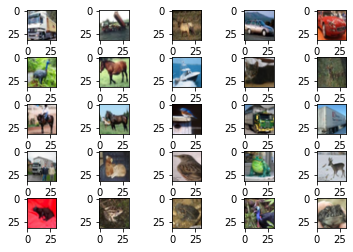

In [12]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def show_example(data, number_of_items):
    width = sqrt(number_of_items)
    width = width if width == int(width) else int(width) + 1
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    for i in range(1, number_of_items+1):
        sub = fig.add_subplot(width, width, i)
        sub.imshow(data[i])
    plt.show()

trainX, trainY, testX, testY = load_dataset()
show_example(trainX, 25)

### Test Harness
In order to experiment on the effect of multiple different architectures easily, the [test harness](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) created by Jason Brownlee was used as a framework.

In [13]:
def get_model_summary(model):
    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='orange', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='cyan', label='train')
    plt.plot(history.history['val_accuracy'], color='green', label='test')
    plt.show()

# run the test harness for evaluating a model
def run_test_harness(model, data_augmentation, epochs):
    #display('Model Summary:', get_model_summary(model))
    # Load data and prepare dataset
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    # Fit the model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=64, validation_data=(testX, testY), verbose=0)
    # Evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    display('Accuracy: ' + str(acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

### Applied models:

#### Optimizers
To allow for comparison between models, the [Keras SGD optimizer](https://keras.io/api/optimizers/sgd/) was applied for all models.

#### Basic CNN Model
This model represents the basic CNN model as discussed in [the car recognition tutorial](https://github.com/tuwien-musicir/DeepLearning_Tutorial/blob/master/Car_recognition.ipynb)

In [14]:
def define_basic_cnn_model():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(16, 3, 3, padding='valid', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Conv2D(16, 3, 3))  # input_shape is only needed in 1st layer
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Flatten()) # Note: Keras does automatic shape inference.

    # Full Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1,activation='sigmoid'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### LeNet
Implementation based on [this](https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9) default Keras implementation.

In [15]:
def define_lenet_model():
    model = Sequential()
    model.add(Conv2D(30, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(32, 32, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(13, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(86, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
#### Alex Net


In [17]:
def define_alexnet_model():
    model = Sequential()
    
    model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(4,4), padding='valid', input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(17))
    model.add(Activation('softmax'))

    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#### VGG Models
Based on the description in this tutorial VGG models were applied:

In [18]:
def define_vgg_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Data Augmentation
Different approaches were applied for data augmentation.

In [19]:
def data_augmentation(trainX, trainY):
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	return datagen.flow(trainX, trainY, batch_size=64)

### Results

'Running estimation for model LeNet'

'Accuracy: 54.97000217437744'

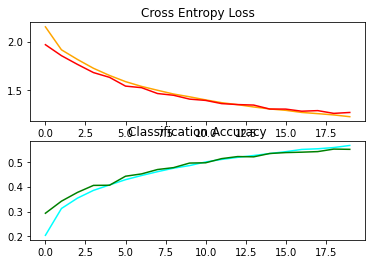

'Time taken for LeNet: 0.915261431535085 minutes'

'Running estimation for model VGG'

'Accuracy: 66.76999926567078'

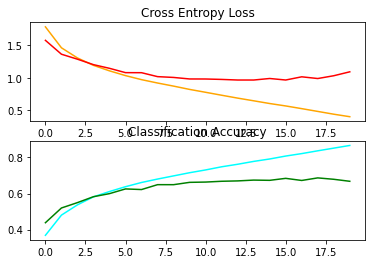

'Time taken for VGG: 1.4916985233624775 minutes'

In [20]:
import time

# Define models
models = [
    #{'name': 'Basic CNN', 'model': define_basic_cnn_model()},
    {'name': 'LeNet', 'model': define_lenet_model()},
    {'name': 'VGG', 'model': define_vgg_model()}
    ]

# Run models and estimate accuracy
max_epochs = 20
for model in models:
    display("Running estimation for model " + model['name'])
    start_time = time.time()
    run_test_harness(model['model'], "hans", max_epochs)
    end_time = time.time()
    display("Time taken for " + model['name'] + ": " + str((end_time - start_time)/60) + " minutes")